In [ ]:
!pip install tensorflow-addons


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import spacy
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, TimeDistributed, Dense, concatenate, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec

In [ ]:
# 1. Data Acquisition
data_path = "/content/Corona2.json"  # Replace with your actual data path
with open(data_path, "r") as f:
    data = json.load(f)


In [ ]:
# 2. Data Exploration (EDA)
named_entities = []
tag_categories = []
entity_values = []

for example in data["examples"]:
    annotations = example.get("annotations", [])
    for annotation in annotations:
        named_entities.append(annotation["tag_name"])
        tag_categories.append(annotation["tag_name"])
        entity_values.append(annotation["value"])

entity_type_counts = pd.Series(named_entities).value_counts()
tag_category_counts = pd.Series(tag_categories).value_counts()
entity_value_counts = pd.Series(entity_values).value_counts()


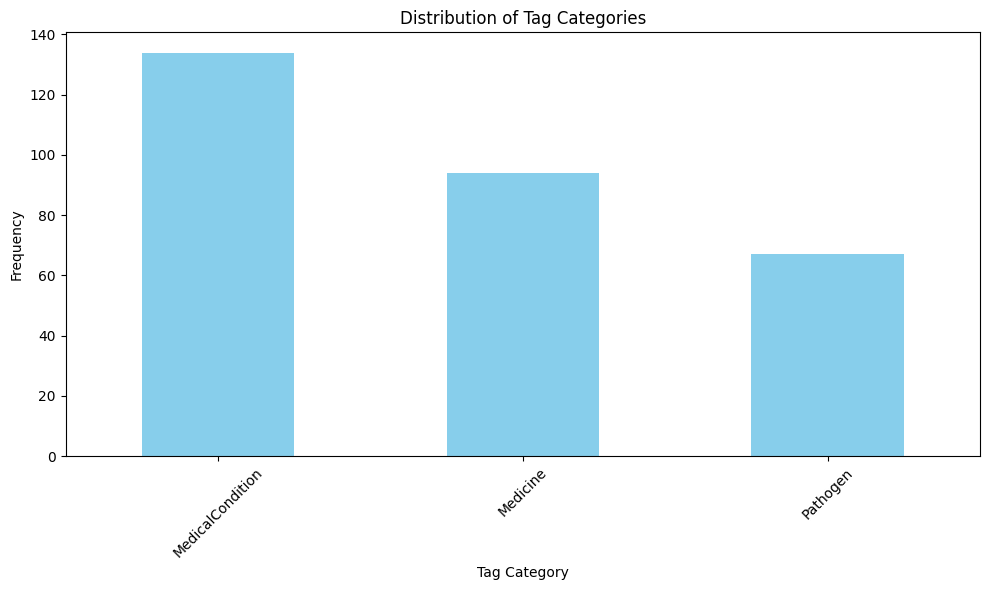

In [ ]:
# (Optional) Visualization of data exploration results
# ... (Your existing visualization code)
# Analyze the distribution of tag categories
plt.figure(figsize=(10, 6))
tag_category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Tag Categories')
plt.xlabel('Tag Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ....................................................

In [ ]:
# Examine the frequency of specific entity values
print("Entity Value Counts:")
print(entity_value_counts)

Entity Value Counts:
diarrhea                      6
methotrexate                  5
HIV                           5
ART                           3
Salmonella                    3
                             ..
nephritis                     1
cracks in the skin            1
intravenous drug injection    1
animal bites                  1
vaginal infections            1
Name: count, Length: 242, dtype: int64


In [ ]:
# 3. Preprocessing and BIO Tagging
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

def validate_annotations(text, annotations):
    """Checks for potential annotation inconsistencies."""
    for annotation in annotations:
        start, end = annotation["start"], annotation["end"]
        if start >= end:
            raise ValueError(f"Invalid annotation: start position {start} is not less than end position {end}")

def bio_tagging(text, annotations):
    """Performs BIO tagging on the text based on provided annotations."""
    doc = nlp(text)
    tokens = [(token.text, token.idx, token.idx + len(token)) for token in doc]
    tags = ["O"] * len(tokens)

    for annotation in annotations:
        entity_start, entity_end = annotation["start"], annotation["end"]
        entity_type = annotation["tag_name"]

        for i, (token_text, token_start, token_end) in enumerate(tokens):
            if token_start == entity_start:
                tags[i] = f"B-{entity_type}"
            elif token_start > entity_start and token_end <= entity_end:
                tags[i] = f"I-{entity_type}"

    # Correct the return statement to iterate over token_text from tokens
    return [(token_text, tag) for token_text, tag in zip([t[0] for t in tokens], tags)]

preprocessed_data = []
for example in data["examples"]:
    text = example["content"]
    annotations = example["annotations"]
    validate_annotations(text, annotations)
    bio_tagged_data = bio_tagging(text, annotations)
    preprocessed_data.append(bio_tagged_data)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
# 4.  Word Embeddings (using Word2Vec)
word2vec_model = Word2Vec(sentences=[[word for word, _ in sentence] for sentence in preprocessed_data],
                         vector_size=100, window=5, min_count=1, workers=4)
# Create embedding matrix
embedding_matrix = np.zeros((len(vocab) + 1, 100))  # +1 for padding token
for word, i in vocab.items():
    try:
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass  # Words not found in Word2Vec will have an embedding of zeros

In [ ]:
# 5.  Character-level Embeddings
def prepare_char_data(data, max_len, char_vocab, max_char_len):
    X_char = []
    for sentence in data:
        sent_chars = []
        for word, tag in sentence:
            word_chars = [char_vocab.get(c, 0) for c in word][:max_char_len]  # Truncate characters beyond max_char_len
            padded_word_chars = pad_sequences([word_chars], maxlen=max_char_len, padding="post", value=0)[0]
            sent_chars.append(padded_word_chars)
        X_char.append(sent_chars)
    return pad_sequences(maxlen=max_len, sequences=X_char, padding="post", value=0, truncating='post')

chars = set([c for sentence in preprocessed_data for word, tag in sentence for c in word])
char_vocab = {c: i + 1 for i, c in enumerate(chars)} # Index 0 is padding
max_char_len = max([len(word) for sentence in preprocessed_data for word, tag in sentence])

# Call prepare_char_data with max_char_len
X_char_train = prepare_char_data(train_data, max_len, char_vocab, max_char_len)
X_char_val = prepare_char_data(val_data, max_len, char_vocab, max_char_len)
X_char_test = prepare_char_data(test_data, max_len, char_vocab, max_char_len)

In [ ]:
# 6.  Model Definition with Word and Character Embeddings
def create_model(vocab_size, embedding_dim, max_len, n_tags, max_char_len, char_vocab_size):
    """Creates the BiLSTM model with word and character embeddings."""

    # Word-level input and embedding
    word_input = Input(shape=(max_len,))
    word_embedding = Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim,
                            weights=[embedding_matrix], trainable=False, input_length=max_len)(word_input)

    # Character-level input and embedding
    char_input = Input(shape=(max_len, max_char_len,))
    char_embedding = TimeDistributed(Embedding(input_dim=char_vocab_size + 1, output_dim=30, input_length=max_char_len))(char_input)
    char_enc = TimeDistributed(Conv1D(filters=30, kernel_size=3, activation="relu", padding='same'))(char_embedding)
    char_enc = TimeDistributed(MaxPooling1D(pool_size=max_char_len))(char_enc)
    char_enc = TimeDistributed(Flatten())(char_enc)

    # Concatenate word and character embeddings
    merged = concatenate([word_embedding, char_enc])

    # BiLSTM Layer
    lstm_layer = Bidirectional(LSTM(units=128, return_sequences=True))(merged)

    # Output Layer
    dense_layer = TimeDistributed(Dense(units=n_tags, activation="softmax"))(lstm_layer)

    model = Model(inputs=[word_input, char_input], outputs=dense_layer)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, TimeDistributed, Dense, concatenate, Conv1D, MaxPooling1D, Flatten  # Import Flatten

In [ ]:
# 7.  Model Training, Evaluation and Hyperparameter Tuning
embedding_dim = 100  # You can experiment with this
n_tags = len(tags)

# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
all_histories = []
for train, test in kfold.split(preprocessed_data):
    print(f"Training for fold {fold_no} ...")

    # Split data into train and validation
    train_data = [preprocessed_data[i] for i in train]
    test_data = [preprocessed_data[i] for i in test]

    # Prepare data for training and validation
    X_word_train, y_train = prepare_training_data(train_data, max_len, vocab, tag_to_index)
    X_word_test, y_test = prepare_training_data(test_data, max_len, vocab, tag_to_index)

    # Prepare character data
    X_char_train = prepare_char_data(train_data, max_len, char_vocab, max_char_len)
    X_char_test = prepare_char_data(test_data, max_len, char_vocab, max_char_len)

    # Create model with word and char embeddings
    model = create_model(len(vocab), embedding_dim, max_len, n_tags, max_char_len, len(char_vocab))

    # Early stopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=5) # Increased patience
    model_checkpoint = ModelCheckpoint(f"best_model_fold_{fold_no}.h5", monitor="val_accuracy", save_best_only=True)

    # Training the model with both word and character inputs
    history = model.fit(
        [X_word_train, X_char_train], np.array(y_train),  # Pass both inputs
        validation_data=([X_word_test, X_char_test], np.array(y_test)),  # Pass both for validation
        batch_size=32,
        epochs=20,
        callbacks=[early_stopping, model_checkpoint]
    )

    all_histories.append(history)

    # Evaluate the model
    test_loss, test_acc = model.evaluate([X_word_test, X_char_test], np.array(y_test), verbose=0)
    print(f"Test Loss for fold {fold_no}: {test_loss}, Test Accuracy: {test_acc}")

    # Generate predictions
    y_pred = model.predict([X_word_test, X_char_test]) # Predict using both inputs
    y_pred = np.argmax(y_pred, axis=-1) # Get the most likely tag index

    # Flatten the predictions and true labels
    y_pred_flat = [tag for sentence in y_pred for tag in sentence]
    y_true_flat = [tag for sentence in y_test for tag in sentence]

    # Classification report
    print(f"Classification Report for fold {fold_no}:")
    print(classification_report(y_true_flat, y_pred_flat, target_names=tags))

    # Confusion Matrix
    print(f"Confusion Matrix for fold {fold_no}:")
    print(confusion_matrix(y_true_flat, y_pred_flat))

    fold_no += 1

Training for fold 1 ...
Epoch 1/20
1/1 [==============================] - 5s 5s/step - loss: 1.9496 - accuracy: 0.0020 - val_loss: 1.8931 - val_accuracy: 0.9579
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 1.8918 - accuracy: 0.9623

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 147ms/step - loss: 1.8918 - accuracy: 0.9623 - val_loss: 1.8327 - val_accuracy: 0.9579
Epoch 3/20
1/1 [==============================] - 0s 145ms/step - loss: 1.8300 - accuracy: 0.9623 - val_loss: 1.7592 - val_accuracy: 0.9579
Epoch 4/20
1/1 [==============================] - 0s 130ms/step - loss: 1.7550 - accuracy: 0.9623 - val_loss: 1.6622 - val_accuracy: 0.9579
Epoch 5/20
1/1 [==============================] - 0s 118ms/step - loss: 1.6561 - accuracy: 0.9623 - val_loss: 1.5243 - val_accuracy: 0.9579
Epoch 6/20
1/1 [==============================] - 0s 125ms/step - loss: 1.5155 - accuracy: 0.9623 - val_loss: 1.3127 - val_accuracy: 0.9579
Epoch 7/20
1/1 [==============================] - 0s 116ms/step - loss: 1.3002 - accuracy: 0.9623 - val_loss: 0.9660 - val_accuracy: 0.9579
Epoch 8/20
1/1 [==============================] - 0s 110ms/step - loss: 0.9497 - accuracy: 0.9623 - val_loss: 0.4960 - val_accuracy: 0.9579
Epoch 9/20
1/1 [===============

1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for fold 1:
                    precision    recall  f1-score   support

B-MedicalCondition       0.00      0.00      0.00        31
        B-Medicine       0.00      0.00      0.00        13
        B-Pathogen       0.00      0.00      0.00        23
I-MedicalCondition       0.00      0.00      0.00        24
        I-Medicine       0.00      0.00      0.00         5
        I-Pathogen       0.00      0.00      0.00         9
                 O       0.96      1.00      0.98      2387

          accuracy                           0.96      2492
         macro avg       0.14      0.14      0.14      2492
      weighted avg       0.92      0.96      0.94      2492

Confusion Matrix for fold 1:
[[   0    0    0    0    0    0   31]
 [   0    0    0    0    0    0   13]
 [   0    0    0    0    0    0   23]
 [   0    0    0    0    0    0   24]
 [   0    0    0    0    0    0    5]
 [   0    0    0    0    0    0    9]
 [   0    0    0    0    0    0 2387]]
Trainin

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 112ms/step - loss: 1.8021 - accuracy: 0.9572 - val_loss: 1.7229 - val_accuracy: 0.9785
Epoch 4/20
1/1 [==============================] - 0s 108ms/step - loss: 1.7230 - accuracy: 0.9572 - val_loss: 1.6189 - val_accuracy: 0.9785
Epoch 5/20
1/1 [==============================] - 0s 85ms/step - loss: 1.6194 - accuracy: 0.9572 - val_loss: 1.4739 - val_accuracy: 0.9785
Epoch 6/20
1/1 [==============================] - 0s 95ms/step - loss: 1.4756 - accuracy: 0.9572 - val_loss: 1.2588 - val_accuracy: 0.9785
Epoch 7/20
1/1 [==============================] - 0s 78ms/step - loss: 1.2633 - accuracy: 0.9572 - val_loss: 0.9170 - val_accuracy: 0.9785
Epoch 8/20
1/1 [==============================] - 0s 76ms/step - loss: 0.9309 - accuracy: 0.9572 - val_loss: 0.4065 - val_accuracy: 0.9785
Epoch 9/20
1/1 [==============================] - 0s 85ms/step - loss: 0.4627 - accuracy: 0.9572 - val_loss: 0.1520 - val_accuracy: 0.9785
Epoch 10/20
1/1 [===================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
1/1 [==============================] - 6s 6s/step - loss: 1.9462 - accuracy: 0.0066 - val_loss: 1.8962 - val_accuracy: 0.9654
Epoch 2/20
1/1 [==============================] - 0s 129ms/step - loss: 1.8934 - accuracy: 0.9603 - val_loss: 1.8421 - val_accuracy: 0.9654
Epoch 3/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 115ms/step - loss: 1.8372 - accuracy: 0.9603 - val_loss: 1.7774 - val_accuracy: 0.9654
Epoch 4/20
1/1 [==============================] - 0s 108ms/step - loss: 1.7701 - accuracy: 0.9603 - val_loss: 1.6934 - val_accuracy: 0.9654
Epoch 5/20
1/1 [==============================] - 0s 84ms/step - loss: 1.6832 - accuracy: 0.9603 - val_loss: 1.5768 - val_accuracy: 0.9654
Epoch 6/20
1/1 [==============================] - 0s 85ms/step - loss: 1.5629 - accuracy: 0.9603 - val_loss: 1.4034 - val_accuracy: 0.9654
Epoch 7/20
1/1 [==============================] - 0s 79ms/step - loss: 1.3846 - accuracy: 0.9603 - val_loss: 1.1262 - val_accuracy: 0.9654
Epoch 8/20
1/1 [==============================] - 0s 79ms/step - loss: 1.1017 - accuracy: 0.9603 - val_loss: 0.6672 - val_accuracy: 0.9654
Epoch 9/20
1/1 [==============================] - 0s 78ms/step - loss: 0.6500 - accuracy: 0.9603 - val_loss: 0.2590 - val_accuracy: 0.9654
Epoch 10/20
1/1 [===================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
1/1 [==============================] - 6s 6s/step - loss: 1.9389 - accuracy: 0.0088 - val_loss: 1.8877 - val_accuracy: 0.9373
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 1.8867 - accuracy: 0.9671

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 142ms/step - loss: 1.8867 - accuracy: 0.9671 - val_loss: 1.8311 - val_accuracy: 0.9373
Epoch 3/20
1/1 [==============================] - 0s 141ms/step - loss: 1.8294 - accuracy: 0.9671 - val_loss: 1.7627 - val_accuracy: 0.9373
Epoch 4/20
1/1 [==============================] - 0s 135ms/step - loss: 1.7600 - accuracy: 0.9671 - val_loss: 1.6740 - val_accuracy: 0.9373
Epoch 5/20
1/1 [==============================] - 0s 123ms/step - loss: 1.6698 - accuracy: 0.9671 - val_loss: 1.5515 - val_accuracy: 0.9373
Epoch 6/20
1/1 [==============================] - 0s 120ms/step - loss: 1.5450 - accuracy: 0.9671 - val_loss: 1.3710 - val_accuracy: 0.9373
Epoch 7/20
1/1 [==============================] - 0s 112ms/step - loss: 1.3600 - accuracy: 0.9671 - val_loss: 1.0826 - val_accuracy: 0.9373
Epoch 8/20
1/1 [==============================] - 0s 118ms/step - loss: 1.0606 - accuracy: 0.9671 - val_loss: 0.6306 - val_accuracy: 0.9373
Epoch 9/20
1/1 [===============

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
1/1 [==============================] - 5s 5s/step - loss: 1.9333 - accuracy: 0.0427 - val_loss: 1.8796 - val_accuracy: 0.9682
Epoch 2/20
1/1 [==============================] - 0s 127ms/step - loss: 1.8839 - accuracy: 0.9597 - val_loss: 1.8193 - val_accuracy: 0.9682
Epoch 3/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 113ms/step - loss: 1.8275 - accuracy: 0.9597 - val_loss: 1.7449 - val_accuracy: 0.9682
Epoch 4/20
1/1 [==============================] - 0s 109ms/step - loss: 1.7575 - accuracy: 0.9597 - val_loss: 1.6466 - val_accuracy: 0.9682
Epoch 5/20
1/1 [==============================] - 0s 97ms/step - loss: 1.6649 - accuracy: 0.9597 - val_loss: 1.5082 - val_accuracy: 0.9682
Epoch 6/20
1/1 [==============================] - 0s 84ms/step - loss: 1.5342 - accuracy: 0.9597 - val_loss: 1.2978 - val_accuracy: 0.9682
Epoch 7/20
1/1 [==============================] - 0s 78ms/step - loss: 1.3354 - accuracy: 0.9597 - val_loss: 0.9458 - val_accuracy: 0.9682
Epoch 8/20
1/1 [==============================] - 0s 82ms/step - loss: 1.0005 - accuracy: 0.9597 - val_loss: 0.4222 - val_accuracy: 0.9682
Epoch 9/20
1/1 [==============================] - 0s 79ms/step - loss: 0.4721 - accuracy: 0.9597 - val_loss: 0.2208 - val_accuracy: 0.9682
Epoch 10/20
1/1 [===================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


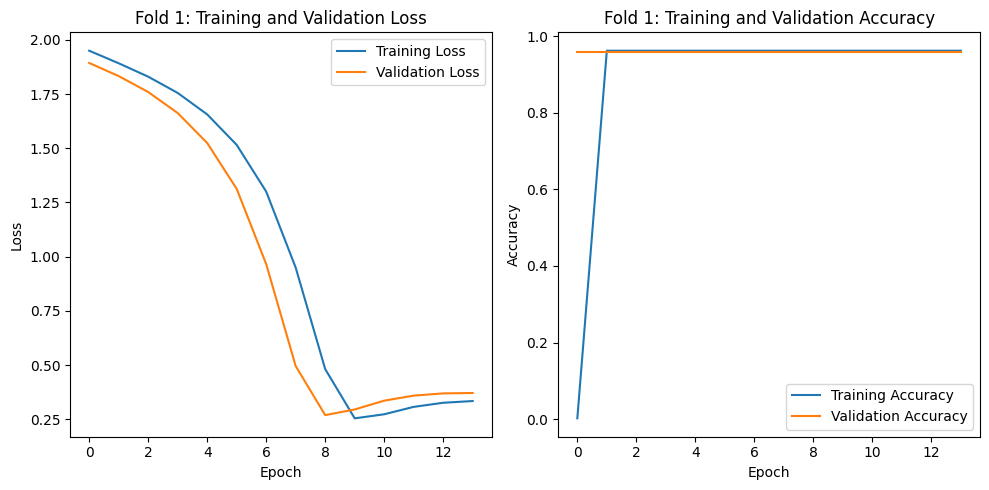

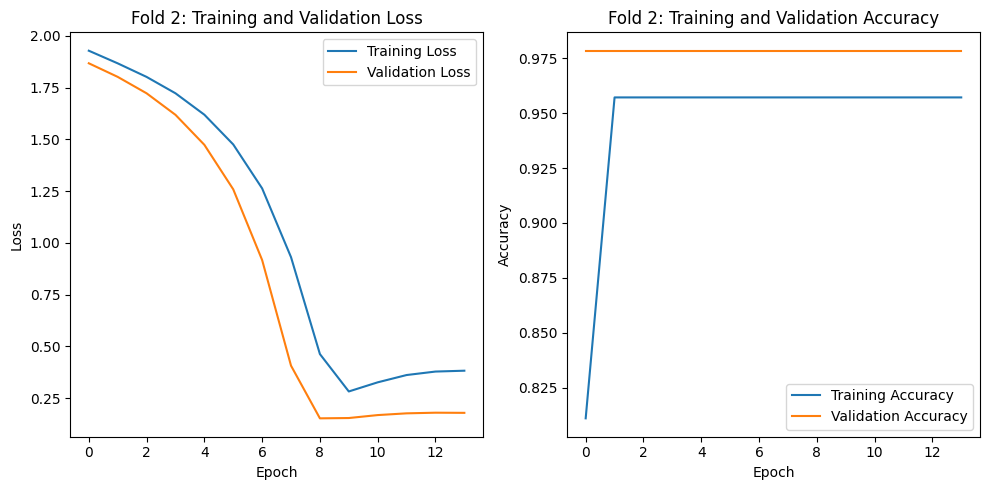

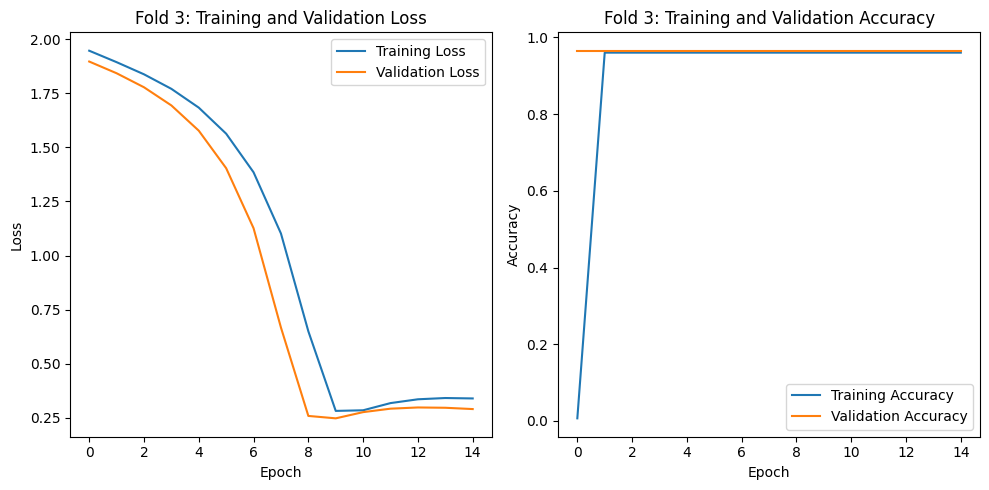

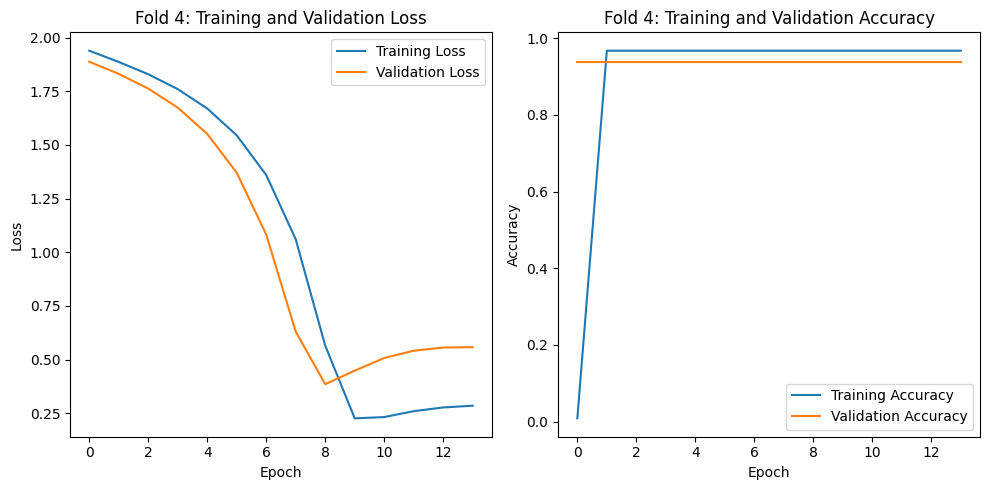

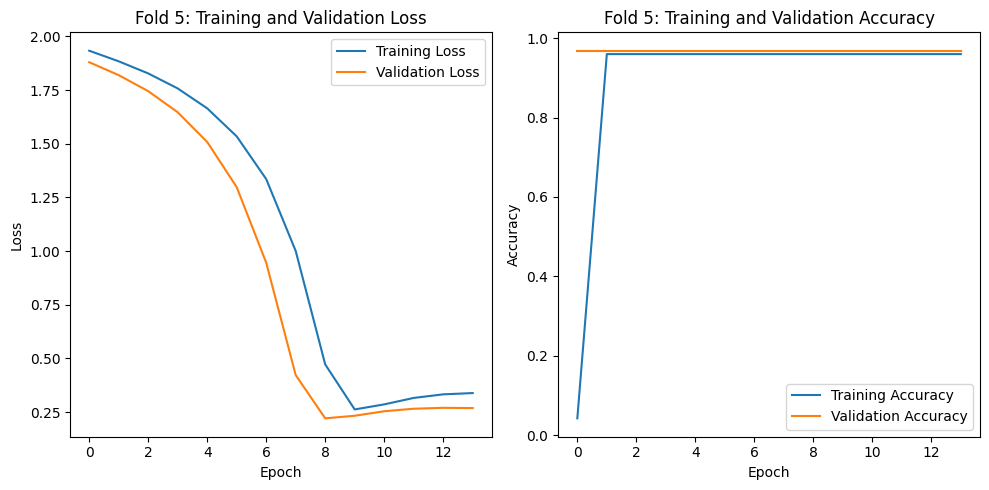

Fold 1: Validation Loss = 0.3719, Validation Accuracy = 0.9579
Fold 2: Validation Loss = 0.1786, Validation Accuracy = 0.9785
Fold 3: Validation Loss = 0.2907, Validation Accuracy = 0.9654
Fold 4: Validation Loss = 0.5580, Validation Accuracy = 0.9373
Fold 5: Validation Loss = 0.2686, Validation Accuracy = 0.9682


In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss for each fold
for i, history in enumerate(all_histories):
    fold_no = i + 1
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold_no}: Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Fold {fold_no}: Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Print validation loss and accuracy for each fold
for i, history in enumerate(all_histories):
    fold_no = i + 1
    val_loss = history.history['val_loss'][-1]
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Fold {fold_no}: Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}")
